# ROC/AUC analysis with corrected De Long Test

# Setup

In [1]:
# install.packages("dplyr")
# install.packages("pROC")
# install.packages("ggplot2")

In [2]:
library(dplyr)
library(pROC)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [3]:
input_dir <- "../8_ROC/1-DUO/DUO_familias-cleaned-LR"                         # CHANGE THIS
output_dir <- "../8_ROC/1-DUO/DUO_ROC"                                        # CHANGE THIS

# Find all cleaned LR files

In [4]:
# Scans the main directory for the needed text file
clean_files <- list.files(
  path       = input_dir,
  pattern    = "^.*_cleanLR\\.txt$",                                
  full.names = TRUE
)

# Exclude files with "27" in the filename                     #### Removes 27 aSTR and 27 aSTR + 90 iiSNPs
clean_files <- clean_files[!grepl("27", basename(clean_files))]

if (length(clean_files) == 0) {
  stop("No cleaned files found.")
}

cat("Found", length(clean_files), "cleaned LR files:\n")
print(basename(clean_files))

Found 5 cleaned LR files:
[1] "Duo_23astr_cleanLR.txt"         "Duo_23astr-90iisnp_cleanLR.txt"
[3] "Duo_23astr-94iisnp_cleanLR.txt" "Duo_90iisnp_cleanLR.txt"       
[5] "Duo_94iisnp_cleanLR.txt"       


# Create function to compute ROC +AUC + De Long

In [ ]:
compute_roc <- function(file_path, output_dir) {
  # Read LR data
  df <- read.table(file_path, header = TRUE)

  # Get marker panel and relationship names from filename
  panel_name <- strsplit(basename(file_path), "_")[[1]][2]
  rel_name   <- strsplit(basename(file_path), "_")[[1]][1]

  # Column labels
  col_true  <- names(df)[1]
  col_unrel <- names(df)[2]

  # Convert LR to log10(LR)
  LR_true  <- log10(df[[col_true]])
  LR_unrel <- log10(df[[col_unrel]])

  # Labels: 1 = related, 0 = unrelated
  labels <- c(rep(1, length(LR_true)), rep(0, length(LR_unrel)))
  scores <- c(LR_true, LR_unrel)

  # ROC via pROC
  roc_obj <- pROC::roc(
    response  = labels,
    predictor = scores,
    quiet     = TRUE,
    direction = "auto"
  )

  # AUC (numeric)
  auc_val <- as.numeric(pROC::auc(roc_obj))

  # 95% CI for AUC using DeLong (default in pROC)
  ci_auc   <- as.numeric(pROC::ci.auc(roc_obj, conf.level = 0.95))
  ci_lower <- ci_auc[1]
  ci_upper <- ci_auc[3]

  # Get ROC coordinates for plotting (TPR vs FPR)
  roc_coords <- pROC::coords(
    roc_obj,
    x   = "all",
    ret = c("specificity", "sensitivity"),
    transpose = FALSE
  )
  roc_df <- data.frame(
    FPR         = 1 - roc_coords$specificity,
    TPR         = roc_coords$sensitivity,
    Panel       = panel_name,
    Relationship = rel_name
  )

  # Individual ROC plot per panel
  roc_plot <- ggplot2::ggplot(roc_df, ggplot2::aes(x = FPR, y = TPR)) +
    ggplot2::geom_line(linewidth = 1.1) +
    ggplot2::geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
    ggplot2::labs(
      title = paste0(
        "ROC - ", rel_name, " - ", panel_name,
        " (AUC=", format(auc_val, digits = 4), ")"
      ),
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)"
    ) +
    ggplot2::theme_minimal(base_size = 20) +
    ggplot2::theme(
      axis.title = ggplot2::element_text(size = 22),
      axis.text  = ggplot2::element_text(size = 18),
      plot.title = ggplot2::element_text(size = 24, face = "bold")
    )

  roc_png <- file.path(
    output_dir,
    paste0("ROC_", rel_name, "_", panel_name, ".png")
  )
  ggplot2::ggsave(roc_png, plot = roc_plot, width = 6, height = 5, dpi = 300)

  cat("Saved individual ROC plot:", roc_png, "\n")

  
  # Best thresholds (log10 LR) using Youden and closest.topleft
  youden <- pROC::coords(
    roc_obj,
    x = "best",
    best.method = "youden",
    ret = c("threshold", "sensitivity", "specificity"),
    transpose = FALSE
  )
  closest <- pROC::coords(
    roc_obj,
    x = "best",
    best.method = "closest.topleft",
    ret = c("threshold", "sensitivity", "specificity"),
    transpose = FALSE
  )

  # Inverse transform to original LR scale (scores are log10 LR)
  youden_lr  <- 10^as.numeric(youden["threshold"])
  closest_lr <- 10^as.numeric(closest["threshold"])

  threshold_row <- data.frame(
    Panel = panel_name,
    Relationship = rel_name,
    Youden_threshold = youden["threshold"],
    Youden_threshold_LR = youden_lr,
    Youden_sensitivity = youden["sensitivity"],
    Youden_specificity = youden["specificity"],
    Closest_threshold = closest["threshold"],
    Closest_threshold_LR = closest_lr,
    Closest_sensitivity = closest["sensitivity"],
    Closest_specificity = closest["specificity"],
    stringsAsFactors = FALSE
  )
  # Summary row for AUC table, including 95% CI for AUC
  auc_row <- data.frame(
    Panel        = panel_name,
    AUC          = auc_val,
    AUC_CI_lower = ci_lower,
    AUC_CI_upper = ci_upper,
    N_sim        = nrow(df),
    stringsAsFactors = FALSE
  )

  # Return:
  # - summary row for AUC table
  # - thresholds table row
  # - roc_df for combined plotting
  # - roc_obj for DeLong AUC comparisons
  list(
    auc_row = auc_row,
    threshold_row = threshold_row,
    roc_df  = roc_df,
    roc_obj = roc_obj
  )
}

# Loop over all panels

In [6]:
auc_list        <- vector("list", length(clean_files))
thresholds_list <- vector("list", length(clean_files))
rocdf_list      <- vector("list", length(clean_files))
roc_list        <- vector("list", length(clean_files))
panel_names     <- character(length(clean_files))

for (i in seq_along(clean_files)) {
  f <- clean_files[i]
  cat("\nProcessing:", basename(f), "\n")
  res <- compute_roc(f, output_dir)

  # Store AUC summary row and ROC coordinates
  auc_list[[i]]        <- res$auc_row
  thresholds_list[[i]] <- res$threshold_row
  rocdf_list[[i]]      <- res$roc_df

  # Store full ROC object and its panel name for DeLong's test
  roc_list[[i]]      <- res$roc_obj
  panel_names[i]     <- res$auc_row$Panel
}

# Name the ROC list elements by panel, for easier access and plotting
names(roc_list) <- panel_names

auc_table       <- bind_rows(auc_list)
thresholds_table <- bind_rows(thresholds_list)
roc_all          <- bind_rows(rocdf_list)

# Output thresholds table
print(thresholds_table)
thresholds_csv <- file.path(output_dir, "LR_thresholds_youden_closest.csv")
write.csv(thresholds_table, thresholds_csv, row.names = FALSE)
cat("
Thresholds table saved to:", thresholds_csv, "
")



Processing: Duo_23astr_cleanLR.txt 


Warning message in ci.auc.roc(roc_obj, conf.level = 0.95):
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”


Saved individual ROC plot: ../8_ROC/1-DUO/DUO_ROC/ROC_Duo_23astr.png 

Processing: Duo_23astr-90iisnp_cleanLR.txt 


Warning message in ci.auc.roc(roc_obj, conf.level = 0.95):
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”


Saved individual ROC plot: ../8_ROC/1-DUO/DUO_ROC/ROC_Duo_23astr-90iisnp.png 

Processing: Duo_23astr-94iisnp_cleanLR.txt 


Warning message in ci.auc.roc(roc_obj, conf.level = 0.95):
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”


Saved individual ROC plot: ../8_ROC/1-DUO/DUO_ROC/ROC_Duo_23astr-94iisnp.png 

Processing: Duo_90iisnp_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/1-DUO/DUO_ROC/ROC_Duo_90iisnp.png 

Processing: Duo_94iisnp_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/1-DUO/DUO_ROC/ROC_Duo_94iisnp.png 
           Panel Relationship threshold sensitivity specificity threshold.1
1         23astr          Duo -1.739951      1.0000      1.0000   -1.739951
2 23astr-90iisnp          Duo -3.523793      1.0000      1.0000   -3.523793
3 23astr-94iisnp          Duo -5.580480      1.0000      1.0000   -5.580480
4        90iisnp          Duo -4.952636      1.0000      0.9998   -3.276769
5        90iisnp          Duo -3.276769      0.9999      0.9999   -3.276769
6        94iisnp          Duo -2.200056      1.0000      0.9998   -2.200056
  sensitivity.1 specificity.1
1        1.0000        1.0000
2        1.0000        1.0000
3        1.0000        1.0000
4        0.9999        0.9999
5        0.9999       

# Save AUC summary table with De Long Tes

In [7]:

# Choose reference panel for DeLong's test (first panel in AUC table - 23aSTR)
reference_panel <- as.character(auc_table$Panel[1])

# Initialize columns for DeLong comparisons
auc_table$AUC_diff_vs_ref   <- NA_real_
auc_table$AUC_diff_CI_lower <- NA_real_
auc_table$AUC_diff_CI_upper <- NA_real_
auc_table$p_Delong          <- NA_real_

# Compute DeLong test for each non-reference panel, including 95% CI for AUC difference
for (i in seq_len(nrow(auc_table))) {
  p <- as.character(auc_table$Panel[i])

  if (!is.na(p) && p != reference_panel) {
    test_res <- suppressWarnings(
      pROC::roc.test(
        roc_list[[p]],
        roc_list[[reference_panel]],
        method      = "delong",
        paired      = TRUE,
        conf.level  = 0.95
      )
    )
    # AUCs of panel and reference
    auc_panel <- as.numeric(test_res$estimate[1])
    auc_ref   <- as.numeric(test_res$estimate[2])
    auc_diff  <- auc_panel - auc_ref
    
    # AUC difference and its 95% CI
    auc_table$AUC_diff_vs_ref[i]   <- auc_diff
    auc_table$AUC_diff_CI_lower[i] <- as.numeric(test_res$conf.int[1])
    auc_table$AUC_diff_CI_upper[i] <- as.numeric(test_res$conf.int[2])
    auc_table$p_Delong[i]          <- as.numeric(test_res$p.value)
  }
}

# Multiple-testing corrections and significance flags at alpha = 0.01
auc_table <- auc_table %>%
  mutate(
    # p_Delong_BH      = ifelse(is.na(p_Delong), NA_real_, p.adjust(p_Delong, method = "BH")),
    p_Delong_Holm    = ifelse(is.na(p_Delong), NA_real_, p.adjust(p_Delong, method = "holm")),
    # Significant_01   = !is.na(p_Delong)      & p_Delong      < 0.01,
    # BH_significant_01   = !is.na(p_Delong_BH)   & p_Delong_BH   < 0.01,
    Holm_significant_01 = !is.na(p_Delong_Holm) & p_Delong_Holm < 0.01
  )

# Generate name for summary table (AUC) and plots (ROC)
summaries_label <- strsplit(basename(clean_files[1]), "_")[[1]][1]

auc_outfile <- file.path(output_dir, paste0("AUC_summary_", summaries_label, "_panels.txt"))

# Enforce desired panel order in AUC table/plots (case-insensitive, but keep original labels)
desired_order <- c(
  "23aSTR",
  "27aSTR",
  "90iiSNP",
  "94iiSNP",
  "23aSTR-90iiSNP",
  "23aSTR-94iiSNP",
  "27aSTR-94iiSNP"
)

auc_table <- auc_table %>%
  mutate(
    Panel       = as.character(Panel),
    Panel_lower = tolower(Panel),
    Panel_order = match(Panel_lower, tolower(desired_order))
  ) %>%
  arrange(is.na(Panel_order), Panel_order, Panel) %>%
  select(-Panel_lower, -Panel_order)

write.table(
  auc_table,
  file      = auc_outfile,
  sep       = "\t",
  quote     = FALSE,
  row.names = FALSE
)

cat("\nAUC summary table saved to:", auc_outfile, "\n")
print(auc_table)


AUC summary table saved to: ../8_ROC/1-DUO/DUO_ROC/AUC_summary_Duo_panels.txt 
           Panel       AUC AUC_CI_lower AUC_CI_upper N_sim AUC_diff_vs_ref
1         23astr 1.0000000    1.0000000            1 10000              NA
2        90iisnp 0.9999998    0.9999994            1 10000        -2.2e-07
3        94iisnp 0.9999998    0.9999996            1 10000        -1.5e-07
4 23astr-90iisnp 1.0000000    1.0000000            1 10000         0.0e+00
5 23astr-94iisnp 1.0000000    1.0000000            1 10000         0.0e+00
  AUC_diff_CI_lower AUC_diff_CI_upper  p_Delong p_Delong_Holm
1                NA                NA        NA            NA
2     -6.430753e-07      2.030753e-07 0.3081150             1
3     -4.085165e-07      1.085165e-07 0.2554391             1
4      0.000000e+00      0.000000e+00 1.0000000             1
5      0.000000e+00      0.000000e+00 1.0000000             1
  Holm_significant_01
1               FALSE
2               FALSE
3               FALSE
4         


# Map raw panel labels to standardized panel labels for AUC and ROC Plots

In [8]:
panel_formatted_map <- c(
  "23astr"          = "23aSTR",
  "23aSTR"          = "23aSTR",
  "27astr"          = "27aSTR",
  "27aSTR"          = "27aSTR",
  "90iisnp"         = "90iiSNP",
  "94iisnp"         = "94iiSNP",
  "23astr-90iisnp"  = "23aSTR + 90iiSNP",
  "23astr-94iisnp"  = "23aSTR + 94iiSNP",
  "27astr-94iisnp"  = "27aSTR + 94iiSNP"
)

# Shared palette keyed by lowercase panel codes for consistent colors
panel_palette_codes <- c(
  "23astr",
  "27astr",
  "90iisnp",
  "94iisnp",
  "23astr-90iisnp",
  "27astr-94iisnp",
  "23astr-94iisnp"
)
panel_palette_base <- setNames(scales::hue_pal()(length(panel_palette_codes)), panel_palette_codes)


# Plot AUC with 95% CI error bars for each panel


AUC with 95% CI plot saved to: ../8_ROC/1-DUO/DUO_ROC/AUC_with_95CI_Duo_panels.png 


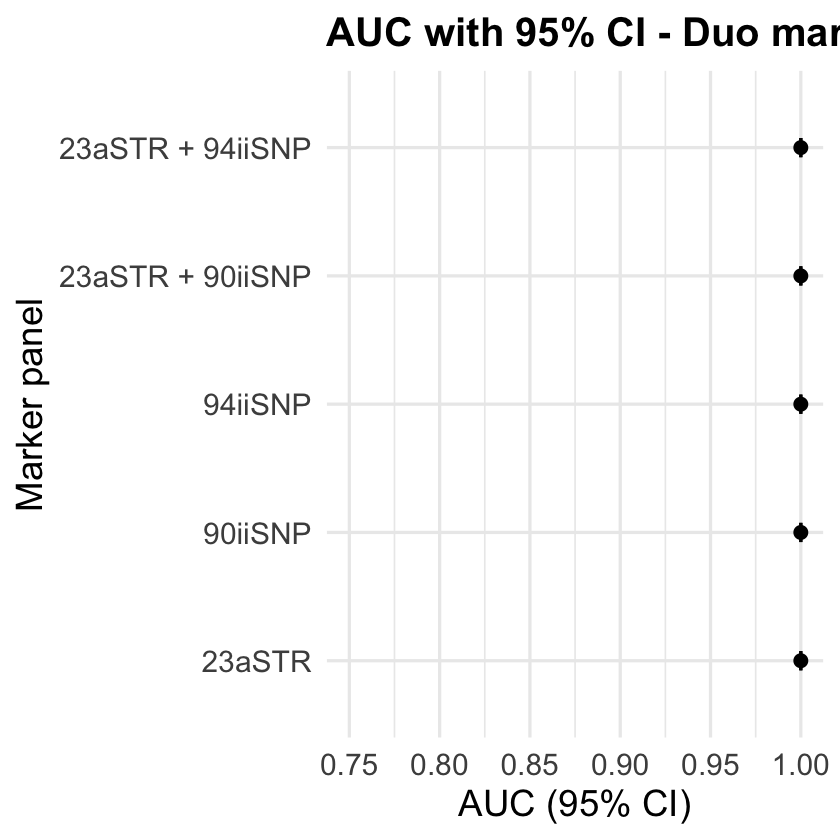

In [9]:
# Ensure panel ordering matches AUC table ordering
auc_table$Panel <- factor(auc_table$Panel, levels = auc_table$Panel)

# Changes raw panel names with formatted panel names for axis label
panel_labels_axis <- panel_formatted_map[tolower(levels(auc_table$Panel))]
panel_labels_axis[is.na(panel_labels_axis)] <- levels(auc_table$Panel)[is.na(panel_labels_axis)]

# AUC Plot
auc_ci_plot <- ggplot(auc_table,
                      aes(x = Panel, y = AUC)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = AUC_CI_lower,
                    ymax = AUC_CI_upper),
                width = 0.15) +
  scale_x_discrete(labels = panel_labels_axis) +
  coord_flip(ylim = c(0.75, 1)) +
  theme_minimal(base_size = 20) +
  theme(
    axis.title = element_text(size = 22),
    axis.text  = element_text(size = 18),
    plot.title = element_text(size = 24, face = "bold")
  ) +
  labs(
    title = paste0("AUC with 95% CI - ", summaries_label, " marker panels"),
    x     = "Marker panel",
    y     = "AUC (95% CI)"
  )

auc_ci_png <- file.path(output_dir,
                        paste0("AUC_with_95CI_", summaries_label, "_panels.png"))
ggsave(auc_ci_png, plot = auc_ci_plot, width = 20, height = 5, dpi = 300)

print(auc_ci_plot)
cat("\nAUC with 95% CI plot saved to:", auc_ci_png, "\n")


# Combined ROC plot (all panels together)


Combined ROC plot saved to: ../8_ROC/1-DUO/DUO_ROC/ROC_Duo_all_panels.png 


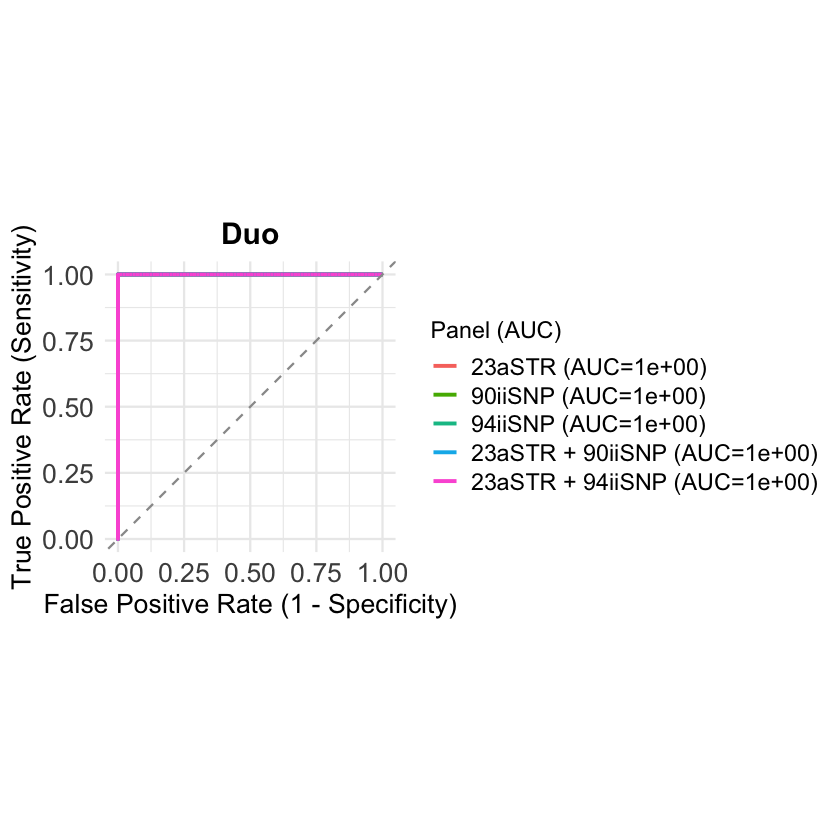

In [10]:
# Combines formatted panel labels with AUC values
auc_labels <- auc_table %>%
  mutate(
    Panel = as.character(Panel),
    Panel_base = panel_formatted_map[tolower(Panel)],
    Panel_base = ifelse(is.na(Panel_base), Panel, Panel_base),
    PanelLabel = paste0(
      Panel_base,
      " (AUC=",
      format(as.numeric(AUC), digits = 6, scientific = TRUE),
      ")"
    )
  )

# Map raw panel labels to "formatted panel Labels + AUC" for legend
panel_label_map <- setNames(auc_labels$PanelLabel, auc_labels$Panel)

# Palette subset aligned to Panel levels
palette_for_plot <- panel_palette_base[tolower(levels(auc_table$Panel))]
names(palette_for_plot) <- levels(auc_table$Panel)

# Enforce panel order for ROC curves
roc_all <- roc_all %>%
  mutate(
    Panel       = as.character(Panel),
    Panel_lower = tolower(Panel),
    Panel_order = match(Panel_lower, tolower(desired_order))
  ) %>%
  arrange(is.na(Panel_order), Panel_order) %>%
  mutate(
    Panel = factor(Panel, levels = unique(Panel))
  ) %>%
  select(-Panel_lower, -Panel_order)

# Build combined ROC plot
p_combined <- ggplot(roc_all, aes(x = FPR, y = TPR, color = Panel)) +
  geom_line(linewidth = 1.1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey60") +
  coord_equal() +
  scale_color_manual(
    values = palette_for_plot,
    labels = panel_label_map,
    drop = FALSE
  ) +
  labs(
    # title = paste0("ROC Curves - ", summaries_label, ", all marker panels"),
    title = paste0(summaries_label),
    x     = "False Positive Rate (1 - Specificity)",
    y     = "True Positive Rate (Sensitivity)",
    color = "Panel (AUC)"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.title  = element_text(size = 16),
    axis.text   = element_text(size = 16),
    legend.title = element_text(size = 14),
    legend.text  = element_text(size = 14),
    plot.title   = element_text(size = 18, face = "bold", hjust = 0.5)
  )

combined_png <- file.path(output_dir, paste0("ROC_", summaries_label, "_all_panels.png"))
ggsave(combined_png, plot = p_combined, width = 8, height = 7, dpi = 300)

print(p_combined)

cat("
Combined ROC plot saved to:", combined_png, "
")
